In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import integrate as sinteg

import integrated_bispectrum

import integrated_bispectrum_vec_general

Note: redshifts have been re-sorted (earliest first)


/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum.py:218: RuntimeWarning: divide by zero encountered in divide
  Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))


Note: redshifts have been re-sorted (earliest first)


/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum_vec_general.py:215: RuntimeWarning: divide by zero encountered in divide
  Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))


In [2]:
#https://github.com/toshiyan/cmblensplus/blob/dcd212906da8039f63839d69e8bb45ebccd55d09/F90/src_utils/bstool.f90#L988
def W3j_approx(l1,l2,l3):
  #ind = np.where((l1+l2+l3)%2 != 0)
  if (l1+l2+l3)%2 != 0:
    result = 0
  else:
    Lh = (l1+l2+l3)*0.5
    a1 = ((Lh-l1+0.5)/(Lh-l1+1))**(Lh-l1+0.25)
    a2 = ((Lh-l2+0.5)/(Lh-l2+1))**(Lh-l2+0.25)
    a3 = ((Lh-l3+0.5)/(Lh-l3+1))**(Lh-l3+0.25)
    b = 1/((Lh-l1+1)*(Lh-l2+1)*(Lh-l3+1))**(0.25)
    result = (-1)**Lh/np.sqrt(2*np.pi) * np.exp(1.5)* (Lh+1)**(-0.25) * a1*a2*a3*b
  #result[ind] = 0
  return result

In [3]:
@np.vectorize
def geom_factor(l1, l2, l3):
    result = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))
    result *= W3j_approx(l1, l2, l3)
    return result


In [4]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar)[0]

In [5]:
integrate_bispectrum_kkk_single = lambda l: integrate_bispectrum_kkk(l, l, l)

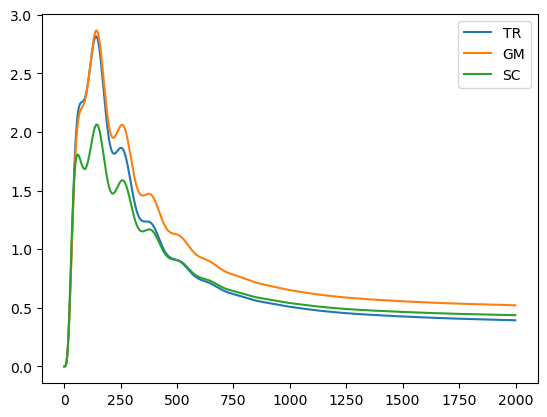

In [14]:
ls = np.arange(1, 2000)
models = ['TR', 'GM', 'SC']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, calculated*1e9*ls**2, label = model)
#plt.xscale('log')
plt.legend()

In [117]:
import vegas

lmin, lmax = 0, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e3

values = []

Rs = np.linspace(0.1, 6, 10)

models = ['TR', 'GM']
results = {}
for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)

        WR = lambda l: np.exp(-l**2*Rradians**2/2)

        @vegas.batchintegrand
        def integrand(x):
            l, thetal = x[:, 0], x[:, 1]
            L, thetaL = x[:, 2], x[:, 3]

            lx, ly = np.cos(thetal)*l, np.sin(thetal)*l
            Lplx = L*np.cos(thetaL)+lx
            Lply = L*np.sin(thetaL)+ly
            Lplv = np.array([Lplx, Lply])
            Lpl = np.linalg.norm(Lplv, axis = 0)
            angle12 = abs(thetal-thetaL)
            angle13 = abs(np.arctan((Lply-ly)/(Lplx-lx))) 
            angle23 = np.pi-angle12-angle13
            value = WR(L)*WR(l)*WR(Lpl)*integrate_bispectrum_kkk(l, L, Lpl, angle12, angle13, angle23, model = model)*geom_factor(l, L, Lpl)**2
            return value/(2*np.pi)**2/(2*np.pi)**2

        result = integ(integrand, nitn = nitn, neval = neval)
        values += [result.mean]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

In [8]:
lmin, lmax = 0, 1000
Ls = np.arange(lmin, lmax)
#L1M, L2M, L3M = np.meshgrid(np.arange(lmin, lmax), np.arange(lmin, lmax), np.arange(lmin, lmax))

In [10]:
values = []

Rs = np.linspace(0.1, 6, 10)

models = ['TR', 'GM']
results = {}
for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)
        sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
        WR = lambda l: np.exp(-(l*(l+1))/2/sigma**2)

        @np.vectorize
        def integrand(L1, L2, L3):
            angle12 = 0
            angle13 = 0
            angle23 = 0
            value = WR(L1)*WR(L2)*WR(L3)*integrate_bispectrum_kkk(L1, L2, L3, angle12, angle13, angle23, model = model)*geom_factor(L1, L2, L3)**2
            return value


        somma = 0
        for L1 in Ls:
            for L2 in Ls:
                for L3 in Ls:
                    if (L3>L1+L2) or (L3<abs(L1-L2)):
                        continue
                    if (L1>L2+L3)or (L1<abs(L2-L3)):
                        continue
                    if (L2>L3+L1) or (L2<abs(L3-L1)):
                        continue
                    if ((L1+L3+L3)%2==1):
                        continue
                    somma += integrand(L1, L2, L3)

        result = somma
        values += [result]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum.py:201: RuntimeWarning: invalid value encountered in divide
  resultS = bfunc(z, k1, grid = False)*bfunc(z, k2, grid = False)*1/2*(k1/k2 + k2/k1)*np.cos(theta12)
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/camb/results.py:960: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = nan
  warnings.warn(
/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum.py:201: RuntimeWarning: divide by zero encountered in divide
  resultS = bfunc(z, k1, grid = False)*bfunc(z, k2, grid = False)*1/2*(k1/k2 + k2/k1)*np.cos(theta12)
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/integrate/

KeyboardInterrupt: 

In [62]:
results_sims = np.load('results.npy', allow_pickle = True).take(0)

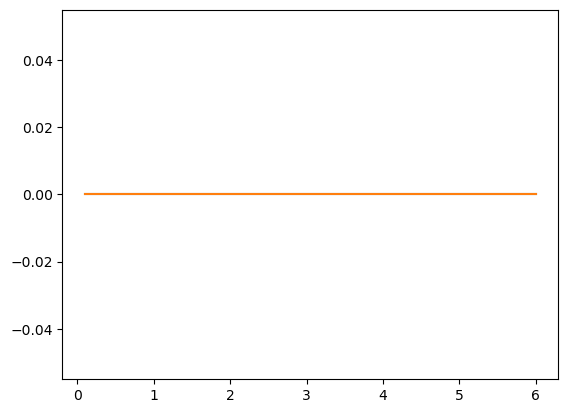

In [118]:
for k, values in results.items():
    plt.plot(Rs, values*1e5, label = k)

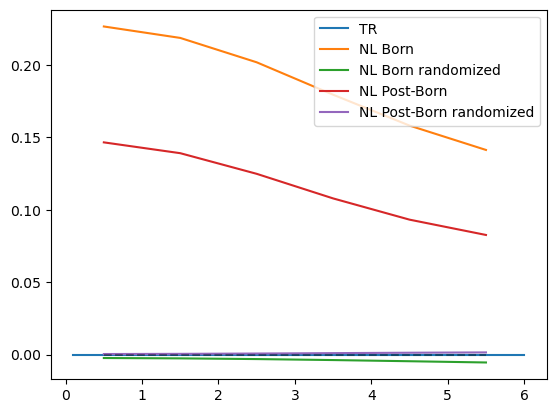

In [102]:
for k, values in results.items():
    plt.plot(Rs, values*1e5, label = k)

fwhms = np.arange(0.5, 6, 1.)
for k, skews in results_sims.items():
    plt.plot(fwhms, np.array(skews), label = k)
plt.hlines(0, fwhms.min(), fwhms.max(), ls = '--', color = 'k', alpha = 0.4)
plt.legend()